# EE 120 Lab 9: Wavelets

**Signals and Systems** at UC Berkeley

Acknowledgements:

- **Spring 2020** (v1.0): Ilya Chugunov, Babak Ayazifar  

In [1]:
from utils.array2gif import write_gif
from utils.test import test_haar_dec, test_haar_rec
from IPython.display import Image
import time
import copy
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

# Background: Wave·let /ˈwāvlit/

Google suggests the definition of a wavelet to be: "a small wave of water; a ripple." Surprisingly, in the signal processing context, this definition isn't too far from the point, and we'll soon find out why. 

So far, all of our frequency domain building blocks — our complex exponentials $e^{i \omega t}$ — correspond to infinite-duration signals in time: they oscillate on and on forever. So, whenever we apply the CTFT or DTFT to a *finite-duration* signal, expressing it as a linear combination of these *infinite-duration* complex exponentials, we need an infinite number of these building blocks to cancel each other out anywhere outside the signal's [region of support](https://en.wikipedia.org/wiki/Support_(mathematics)). 

This issue led to the introduction of the Discrete Fourier Transform (DFT), specially designed for finite-duration signals, but introduced a new problem: many discrete-time signals have an **inefficient representation** in the DFT. That is, the signals require an incommensurately large number of nonzero DFT coefficients to encode, given their simple time-domain behavior. As we'll see in this lab, the issue is that if you try to write something that doesn't look like sines and cosines as a sum of sines and cosines, it'll take you a *lot* of sines and cosines to come close.

As a prototypical example, let's consider a 256-point signal $x(n)$ defined as:

$$x(n) = \begin{cases}
    2, & \text{for } 0 \leq n < 128 \\
    1, & \text{for } 128 \leq n < 192 \\
    0, & \text{for } 192 \leq n < 256
  \end{cases}$$ 
  
and zero elsewhere. This is just a sum of two 128-point [rectangular](https://en.wikipedia.org/wiki/Rectangular_function) signals. 

Let's plot $x$ as well as the magnitude of its DFT coefficients. We'll also verify that taking the inverse DFT perfectly reconstructs the signal.

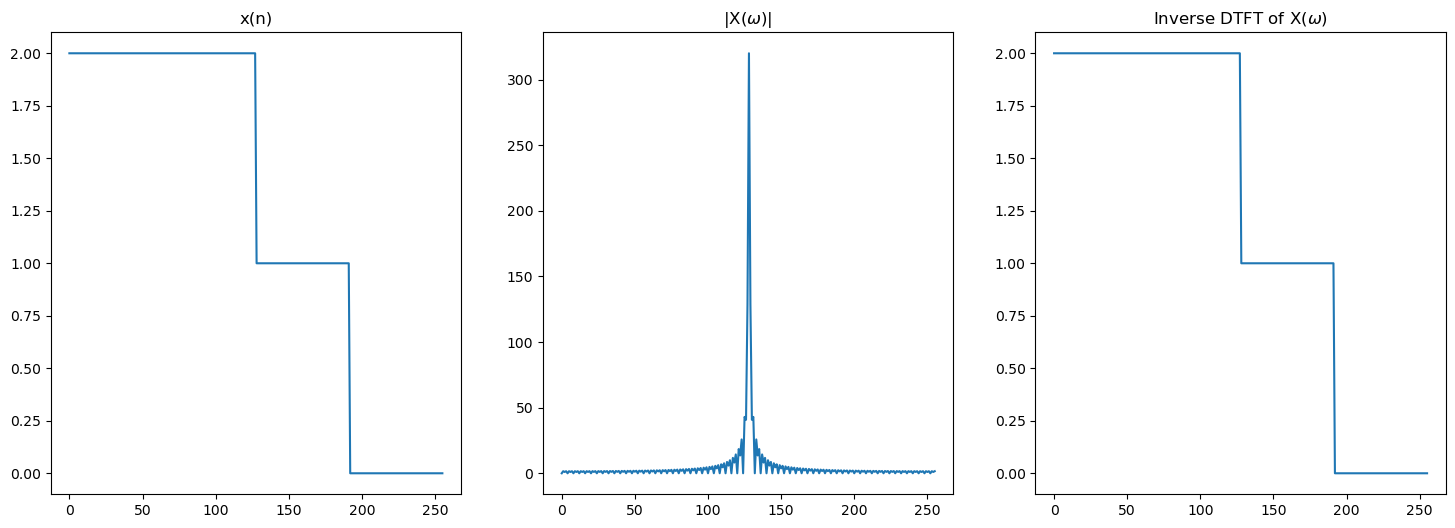

In [2]:
x = np.concatenate((np.ones(128) * 2, np.ones(64), np.zeros(64)))
X = np.fft.fftshift(np.fft.fft(x))
x_ifft = np.fft.ifft(np.fft.fftshift(X))

fig, axs = plt.subplots(1, 3, figsize=(18,6))
axs[0].plot(x)
axs[0].set_title("x(n)")
axs[0].set_ylim(-0.1,2.1)
axs[1].plot(np.abs(X))
axs[1].set_title("|X($\omega$)|")
axs[2].plot(np.abs(x_ifft))
axs[2].set_title("Inverse DTFT of X($\omega$)")
axs[2].set_ylim(-0.1,2.1)
plt.show()

Ignoring the differences in space required for encoding data types for now (e.g., the number of bytes used to encode a `float64` versus a `complex128`), we find that just as $x$ takes 256 coefficients to encode in the time domain, it also takes 256 DFT coefficients to encode. If we keep all 256 DFT coefficients, we can recover $x$ in the time-domain with the inverse DFT. So far, nothing new or surprising.

How important are the various DFT coefficients though? What if we throw away some coefficients? Let's see what happens if we zero out every other coefficient, effectively downsampling the DFT by 2.

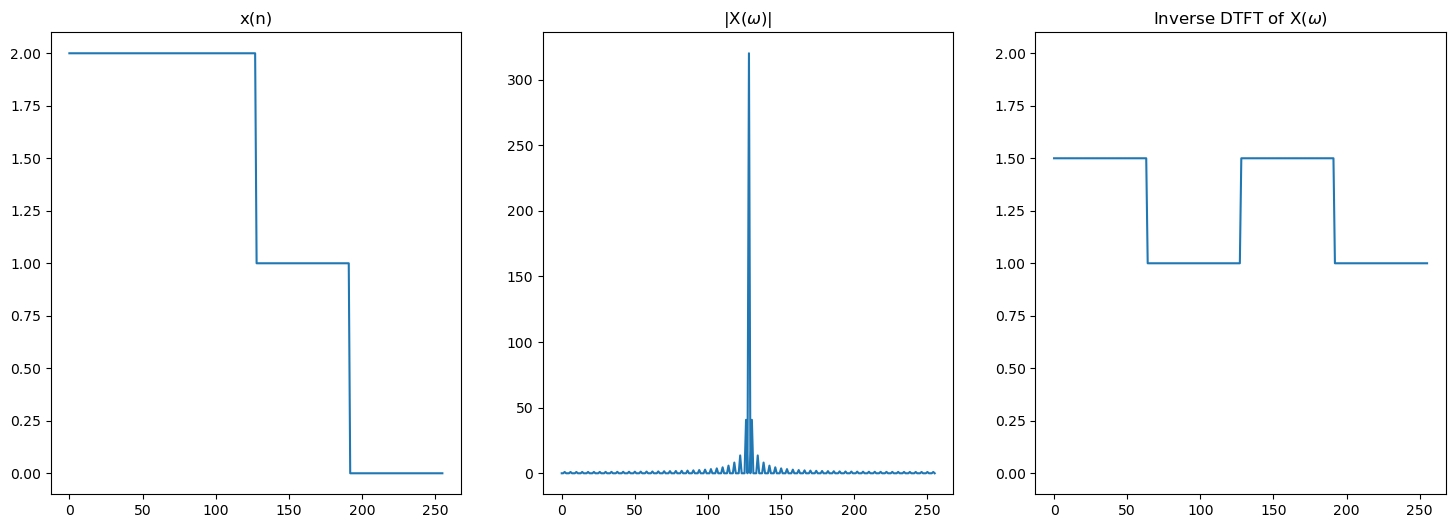

In [3]:
X = np.fft.fftshift(np.fft.fft(x))
X[1::2] = 0 # zero every other coefficient
x_ifft = np.fft.ifft(np.fft.fftshift(X))

fig, axs = plt.subplots(1, 3, figsize=(18,6))
axs[0].plot(x)
axs[0].set_title("x(n)")
axs[0].set_ylim(-0.1,2.1)
axs[1].plot(np.abs(X))
axs[1].set_title("|X($\omega$)|")
axs[2].plot(np.abs(x_ifft))
axs[2].set_title("Inverse DTFT of X($\omega$)")
axs[2].set_ylim(-0.1,2.1)
plt.show()

Though we only have to store half the coefficients, we in exchange don't exactly reconstruct the original signal, rather getting a scaled and aliased version of it. Seems those DFT coefficients are quite significant.

Since throwing out half the DFT coefficients didn't work too well, let's take a slightly more principled approach. $x$ is piecewise-constant; what would happen if we were to discard just the half of the coefficients corresponding to the high-frequency components?

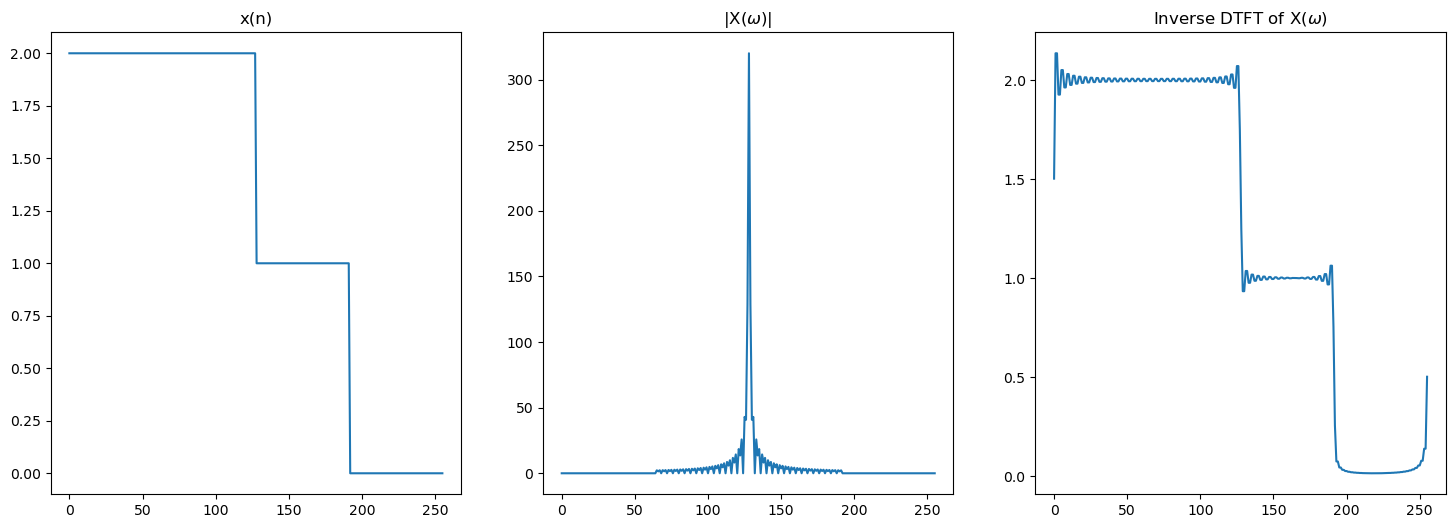

In [5]:
X = np.fft.fftshift(np.fft.fft(x))
X[:64] = 0  # zero out DTFT from -pi to -pi/2
X[192:] = 0 # zero out DTFT from pi/2 to pi
x_ifft = np.fft.ifft(np.fft.fftshift(X))

fig, axs = plt.subplots(1, 3, figsize=(18,6))
axs[0].plot(x)
axs[0].set_title("x(n)")
axs[1].plot(np.abs(X))
axs[1].set_title("|X($\omega$)|")
axs[2].plot(np.abs(x_ifft))
axs[2].set_title("Inverse DTFT of X($\omega$)")
plt.show()

Again, we throw out half the coefficients, and our reconstruction of $x$ suffers as a result, with an obvious [Gibbs artifact](https://en.wikipedia.org/wiki/Gibbs_phenomenon) in the result. This happens because those high frequency components of the DFT that we discarded were responsible for preserving the fast changes in signal (edges) at $n = 128$ and $n=192$. 

This is what we mean when we say $x$ has an *inefficient representation* in the DFT basis: $x$ is very simple to describe in the time domain (there's only two places where it does anything interesting — its edges), but in the frequency domain every coefficient plays an essential role in its reconstruction, meaning we have to keep all 256 pesky coefficients in computer memory.

We know $x$ is just constructed from rectangles! If only we had a basis made of rectangles and not useless smooth sinusoids.

# Q1: The Haar Wavelet: a basis made of rectangles and not useless smooth sinusoids.

<img src="figs/curves.svg" alt="drawing" style="width:60%;"/>

Before we dissect the Haar Wavelet, it's worth emphasizing that the main lessons of this lab aren't in the details of wavelets that are emphasized in later courses like EE 123 and 225B (in particular, the theory behind [mother wavelets](https://en.wikipedia.org/wiki/Wavelet#Mother_wavelet) and [time-frequency tradeoffs](https://en.wikipedia.org/wiki/Time%E2%80%93frequency_representation)), but rather on the philosophy behind their existence: **generalization**.

## Covering all our bases

The DFT analysis equation, 

$$ X[k] =\sum_{n=0}^{N-1} x(n) \cdot \underbrace{e^{-\frac{i 2 \pi}{N} k n}}_{\phi_k^*(n)} = \langle x, \phi_k \rangle ,$$

tells us that we can compute DFT coefficients by projecting our signal onto the basis $\{\phi_0, ..., \phi_{N-1}\}$, where $\phi_k(n) = e^{i \frac{2\pi}{N} kn}$. But is this complex exponential somehow special, such that replacing the $\phi$'s with another basis is impossible? Does it form a basis better than any other?

Well no, not really.  

Complex exponentials are convenient: they're easy to manipulate mathematically, and many real-life signals can be efficiently represented by using them as a basis. However, there are also many classes of signals, such as the one we saw in the previous part of the lab, that aren't efficiently expressible as a linear combination by complex exponentials. For this reason, back in the 1980s and 1990s, mathematicians, physicists, and engineers alike were racing to use the coolest wavelet bases they could for applications from computer vision to quantum field theory [1]. And there were quite a few to choose from: we had [Mathieu](https://en.wikipedia.org/wiki/Mathieu_wavelet), [Legendre](https://en.wikipedia.org/wiki/Legendre_wavelet), and [Daubachies](https://en.wikipedia.org/wiki/Daubechies_wavelet) wavelets, or if that wasn't enough last names for you, you could use a [Cohen–Daubechies–Feauveau](https://en.wikipedia.org/wiki/Cohen%E2%80%93Daubechies%E2%80%93Feauveau_wavelet) wavelet! There were even such questionably named wavelets as the [Mexican Hat](https://en.wikipedia.org/wiki/Mexican_hat_wavelet) and its cousin the [Complex Mexican Hat](https://en.wikipedia.org/wiki/Complex_Mexican_hat_wavelet).

With these new bases we also have a new synthesis equation for discrete time,

#### $$ \begin{equation} x(n)= \left( \sum_{s} \sum_{u} d_{s, u} \cdot \Psi_{s, u}(n) \right) + \alpha \cdot \Phi(n) \end{equation},$$

where

#### $$ d_{s, u} = \langle x , \Psi_{s, u} \rangle \quad \quad \text{and} \quad \quad \alpha = \langle x, \Phi \rangle .$$

Now, our signal $x$ is a weighted sum of *mother wavelets* $\Psi_{s, u}$, and one *father wavelet* $\Phi$. For now, it's fine to think of these as some arbitrary orthonormal bases.

The weighting coefficients, $d_{s,u}$ and $a$, are found by taking the inner product of our signal vector and basis vectors. Just as with the DFT, they represent how well the signal "matches" or correlates with that particular *atom* (i.e., basis vector, or *wavelet*). 

In the case of the Haar basis, our wavelets look like this:

<img src="figs/haar_scales.svg" alt="drawing" style="width:80%;"/>

Let's start out by creating the first 4 Haar wavelets, which we'll call `phi`, `psi_0_0`, `psi_1_0`, and `psi_1_1`.

These wavelets should:
   1. Be length 256 vectors;
   2. Follow the shape of the figure above (symmetric about the x-axis); and
   3. Have a euclidean norm (square root of the inner product of the signal with itself) of 1.
    
`np.linalg.norm` might be useful here.

##### Side Note: if the assumptions we make in this lab are unsatisfactory to you, it's because we leave the rigorous mathematics for EE 123, which takes deep dive into this territory of signal analysis and much much more!

In [7]:
### TODO: your code here
phi = np.ones(256)
phi = phi / np.linalg.norm(phi)
psi_0_0 = np.concatenate((np.ones(128), -1 * np.ones(128)))
psi_0_0 = psi_0_0 / np.linalg.norm(psi_0_0)
psi_1_0 = np.concatenate((np.ones(64), -1 * np.ones(64), np.zeros(128)))
psi_1_0 = psi_1_0 / np.linalg.norm(psi_1_0)
psi_1_1 = np.concatenate((np.zeros(128), np.ones(64), -1 * np.ones(64)))
psi_1_1 = psi_1_1 / np.linalg.norm(psi_1_1)

Let's plot these wavelets to see if they look correct.

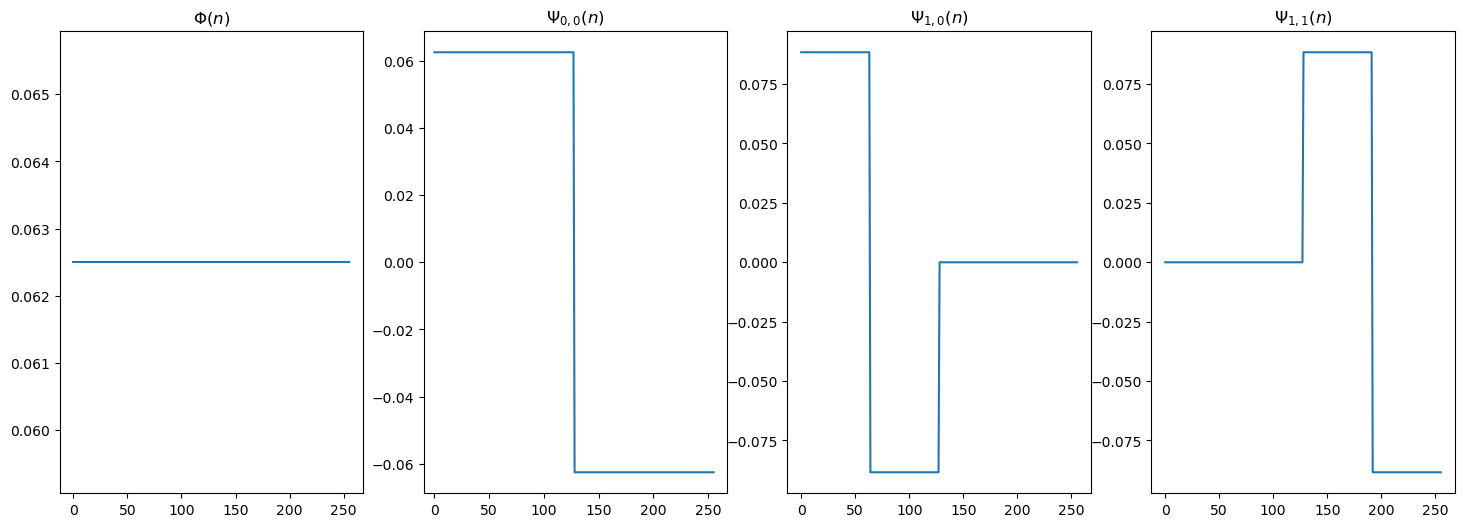

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(18,6))
axs[0].plot(phi)
axs[0].set_title("$\Phi(n)$")
axs[1].set_xlim(-10, 267)
axs[1].plot(psi_0_0)
axs[1].set_title("$\Psi_{0,0}(n)$")
axs[2].plot(psi_1_0)
axs[2].set_title("$\Psi_{1,0}(n)$")
axs[3].plot(psi_1_1)
axs[3].set_title("$\Psi_{1,1}(n)$")
plt.show()

Now, let's check the orthonormality of this basis:

In [9]:
print("<phi     , phi>     = ", np.dot(phi, phi).round(3))
print("<psi_0_0 , psi_0_0> = ", np.dot(psi_0_0, psi_0_0).round(3))
print("<psi_1_0 , psi_1_0> = ", np.dot(psi_1_0, psi_1_0).round(3))
print("<psi_1_1 , psi_1_1> = ", np.dot(psi_1_1, psi_1_1).round(3))

<phi     , phi>     =  1.0
<psi_0_0 , psi_0_0> =  1.0
<psi_1_0 , psi_1_0> =  1.0
<psi_1_1 , psi_1_1> =  1.0


In [10]:
print("<phi     , psi_0_0> = ", np.dot(phi, psi_0_0).round(3))
print("<psi_0_0 , psi_1_0> = ", np.dot(psi_0_0, psi_1_0).round(3))
print("<psi_1_0 , psi_1_1> = ", np.dot(psi_1_0, psi_1_1).round(3))

<phi     , psi_0_0> =  0.0
<psi_0_0 , psi_1_0> =  0.0
<psi_1_0 , psi_1_1> =  0.0


**Q:** Are the wavelets orthonormal? How can you tell?

<span style="color:dodgerblue">**A:** (TODO)

Next, calculate coefficients `a`, `d_0_0`, `d_1_0`, `d_1_1` as in Eq 1. above for our original signal x.

In [11]:
x = np.concatenate((np.ones(128)*2, np.ones(64), np.zeros(64))) # as a reminder

In [12]:
# TODO: your code here
a = np.dot(x, phi)
d_0_0 = np.dot(x, psi_0_0)
d_1_0 = np.dot(x, psi_1_0)
d_1_1 = np.dot(x, psi_1_1)
print("a = ", a, ", d_0_0 = ", d_0_0, ", d_1_0 = ", d_1_0, ", d_1_1 = ", d_1_1)

a =  20.0 , d_0_0 =  12.0 , d_1_0 =  0.0 , d_1_1 =  5.65685424949238


Now create and plot a reconstructed `x_hat` by via the synthesis equation in Eq. 1 (you can just sum the products manually for now, no need for a for loop).  
If everything went correctly, the original signal `x` and `x_hat` should look identical.

In [13]:
# TODO: your code here
x_hat = d_0_0 * psi_0_0 + d_1_0 * psi_1_0 + d_1_1 * psi_1_1 + a * phi

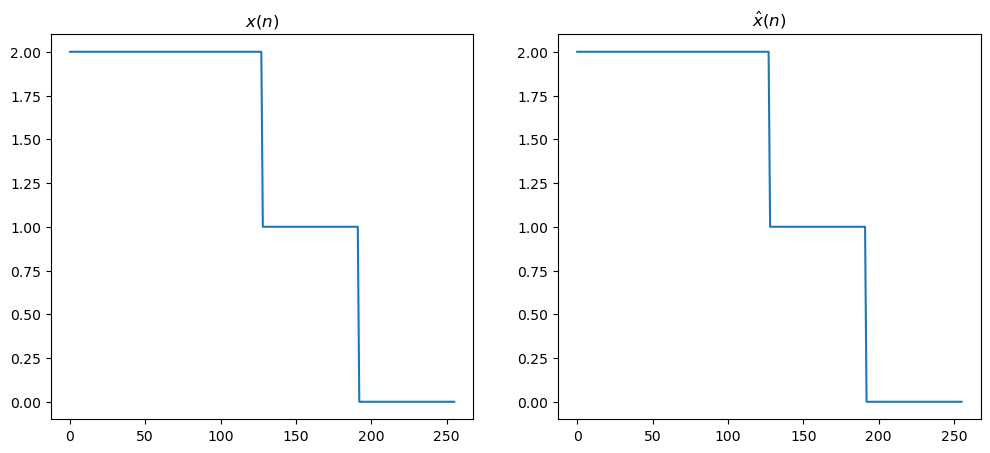

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))
axs[0].plot(x)
axs[0].set_title("$x(n)$")
axs[1].plot(x_hat)
axs[1].set_title("$\hat{x}(n)$")
plt.show()

Incredible! We can reconstruct the time-domain $x$ perfectly with a measly 4 wavelet coefficients! That's 64 times less memory than we had to store for the DTFT coefficients with no loss in signal information.

But what have we learned about the signal itself? Does this Haar wavelet transform tell us any information like the DTFT? Yes, and more!

Let's zoom in on our *level 1 wavelets* (level here being equivalent to $s$, the first index of our wavelets).
 
 We can see that both $\Psi_{1,0}$ and $\Psi_{1,1}$, shown below

<img src="figs/level1.svg" alt="drawing" style="width:48%;"/>

are finite-duration signals. In particular, $\Psi_{1,0}$ is only nonzero for the left side of the vector, and $\Psi_{1,1}$ is nonzero for the right side.

If we zoom in on higher level wavelets, we see they get thinner and thinner:

<img src="figs/scales.svg" alt="drawing" style="width:55%;"/>

In other words, wavelets encode both frequency information (as $u$ increases, the wavelet becomes thinner, detecting higher frequency changes in the signal) and temporal information (as $s$ changes you sample different parts of $x(n)$). Here's a way to visualize this phenomenon:

<img src="figs/time_frequency_blocks.svg" alt="drawing" style="width:40%;"/>

Each complex exponential from the DTFT corresponds to an infinitely long signal ($e^{i \omega n}$ doesn't decay for large n) but at one specific frequency, whereas a wavelet can correspond to both a range of frequencies (depending on it's shape) and a range of time (depending on its support in time). The size of these boxes in time-frequency space is limited by the [uncertainty principle](https://en.wikipedia.org/wiki/Uncertainty_principle#Harmonic_analysis), the same one you might have heard of from quantum physics.

With that in mind, as well as the wavelet coefficients you computed (reproduced below), answer the following questions.

In [15]:
print("a = ", a, ", d_0_0 = ", d_0_0, ", d_1_0 = ", d_1_0, ", d_1_1 = ", d_1_1)

a =  20.0 , d_0_0 =  12.0 , d_1_0 =  0.0 , d_1_1 =  5.65685424949238


**Q:** What do you notice about the coefficient `d_1_0`? What does this say about the signal behaviour in the left half of $x(n)$?

<span style="color:dodgerblue">**A:** (TODO)

**Q:** Which is larger, `d_0_0` or `d_1_0`? Does this mean $x(n)$ is a predominantly low-frequency or high-frequency signal?

<span style="color:dodgerblue">**A:** (TODO)

# Q2: Where do you store wavelets? In a filter bank.

Though we've gained some intuition about the Haar wavelet and its coefficients, manually calculating them is quite tedious. We stopped at the first level wavelets and coefficients, but in general, a signal of length $N$ would require $\log_2(N)$ wavelet levels, each with $2^u$ coefficients to calculate. This would be an absolute computational nightmare to do by hand if we had to manually calculate all the dot products.

Luckily, the Haar basis is quite convenient. For both signal decomposition (i.e., analysis) and reconstruction (i.e., synthesis), the process can be implemented via a [*filter bank*](https://en.wikipedia.org/wiki/Filter_bank): a recursively structured set of down or upsamplers convolutions.

## Haar Analysis

Here's the block diagram for our Haar decomposition filter bank (aka, applying the "analysis equation"):

<img src="figs/haardec.svg" alt="drawing" style="width:70%;"/>

We see that each step of the process involves first passing the signal $x$ through $g$, a low-pass filter, and $h$, a high-pass filter, before down-sampling the produced signals by a factor of two. Rather than operating with various scales of $\Psi_{s,u}$, horizontally compressing our basis functions, we're instead scaling the signal $x$ itself, allowing us to keep the same simple set of filters $g$ and $h$ through the whole process.

## Haar Synthesis

Similarly, this is the block diagram for Haar reconstruction (aka, applying the "synthesis equation"):

<img src="figs/haarrec.svg" alt="drawing" style="width:70%;"/>

As you can see, this follows the same principles as decomposition but in reverse. The filters $\hat{g}$ and $\hat{h}$ are time-reversed versions $g$ and $h$, and the downsampling operator is replaced with upsampling (in this case an [expander](https://en.wikipedia.org/wiki/Upsampling), inserting zeroes between signal elements).

Note that for both decomposition and reconstruction, the coefficient outputs are now arrays, meaning that to recover `d_s_u` you'd need to look at the $u$-th element of the $s$-th coefficient array.

**Q:** Implement the `haar_dec` and `haar_rec` functions as outlined in the block diagrams above. We've given you an upsampler helper function and test code for convenience.

**You may want to use the following functions:**  
    [np.convolve](https://docs.scipy.org/doc/numpy/reference/generated/numpy.convolve.html), [list.insert()](https://www.programiz.com/python-programming/methods/list/insert), and [list.pop()](https://www.programiz.com/python-programming/methods/list/pop)

In [20]:
def haar_dec(signal):
    """ Perform Haar decomposition of signal as in the block diagram.
        Output should be a list of lists:
        
        coefficients : [[a], [d_0_0], [level 1 coefficients], ... , [level N coefficients]]
        
        Hints:  - downsample by removing every other element starting at the second:
                [a, b, c, d, e, f] -> [b, d, f]
                
                - The a coefficient will be the output of the last g(n) downsampled
                    -- this will only be a single coefficient
                - The d_0_0 coefficient will be the output of the last h(n) downsampled
                    -- this will only be a single coefficient
        
    """ 
    g = np.array([1,1])/np.sqrt(2) 
    h = np.array([1,-1])/np.sqrt(2)
    
    coefficients = []
    
    #### TODO: your code here
    level_signal = signal.copy()
    
    while len(level_signal) > 1:
        a = np.convolve(level_signal, g, mode='valid')[::2]
        d = np.convolve(level_signal, h, mode='valid')[::2]
        
        coefficients.append(a.tolist())
        level_signal = d
    
    coefficients.append(level_signal.tolist())  # Adding the last detail coefficient
        
    return coefficients

def upsample_2(coefficients):
    """ Helper function. Upsamples signal by two
        via inserting zeroes (Expander block). 
    """
    if len(coefficients) == 1:
        return [coefficients[0], 0]
    
    out = np.zeros(2 * len(coefficients))
    out[::2] = coefficients
    return out

def haar_rec(coefficients):
    """ Perform Haar reconstruction as in the block diagram.
    """
    coefficients = copy.deepcopy(coefficients)
    g_hat = np.array([1,1])/np.sqrt(2) 
    h_hat = np.array([-1,1])/np.sqrt(2)
    signal = 0
    
    #### TODO: your code here
        
    return signal

Run the tests below to check the validity of your code:

In [21]:
_ = test_haar_dec(haar_dec)

Wavelet level 0 differed in length from test.


In [ ]:
_ = test_haar_rec(haar_rec)

We can also check that `haar_rec` of the `haar_dec` of a signal returns the same signal.  
Compare $x$ and $\hat{x}$ below and verify that they look identical.

In [ ]:
x_hat = haar_rec(haar_dec(x))

fig, axs = plt.subplots(1, 2, figsize=(12,5))
axs[0].plot(x)
axs[0].set_title("$x(n)$")
axs[1].plot(x_hat)
axs[1].set_title("$\hat{x}(n)$")
plt.show()

The simplicity and recursive nature of this Haar decomposition and reconstruction process, combined with taking advantage of vectorized operation in NumPy, allows this code to run blazingly fast.  


For an arbitrary $2^{20} = 1048576$-point signal, the code should take only a fraction of a second to run:

In [ ]:
long_test = np.random.randn(1048576)
start = time.time()
long_test = haar_dec(long_test)
print("Decomposition took {0} seconds.".format(time.time()-start))
start = time.time()
long_test = haar_rec(long_test)
print("Reconstruction took {0} seconds.".format(time.time()-start))

**Q:** What in this implementation of Haar decomposition allows it to run faster (i.e., perform less operations) than finding coefficients directly via dot products as we were doing earlier? 

<span style="color:dodgerblue">**A:** (TODO)

# Q3: Applications

Having developed some basic intuition for wavelets and how they generalize the DFT, we'll now explore some of their applications.

## Q3a: Compression

As mentioned before, wavelets have applications in fields from MRI to quantum physics, but for now we'll focus our attention on image processing.

For the purposes of this lab, we'll treat images as just folded-up one-dimensional signals to simplify things, but there are the two-dimensional (and more generally, N-dimensional) [discrete wavelet transform](https://en.wikipedia.org/wiki/Discrete_wavelet_transform) that we should be using for higher dimensional data.

Let's load an image and take its Haar decomposition:

In [ ]:
blocks = plt.imread('data/blocks.tif') # load image from file

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(blocks, cmap='gray')
plt.show()

In [ ]:
blocks_dec = haar_dec(blocks.flatten())

In [ ]:
blocks_rec = haar_rec(blocks_dec).reshape(512,512)

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(blocks_rec, cmap='gray')
plt.show()

Just as in the 1D case, we're able to successfully decompose and reconstruct our blocky image. Here we use [np.flatten()](https://numpy.org/doc/1.18/reference/generated/numpy.ndarray.flatten.html) to collapse a multidimensional array into a 1D array, and [np.reshape()](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html) to convert this 1D array back into 2D.  

These functions might be useful later.

**Q:** Why might Haar be a good basis to represent this image? How is this image similar to the signal $x$ we used in the 1D parts of the lab?

<span style="color:dodgerblue">**A:** (TODO)

**Q:** Use the code block below to help answer this:  
1. What coefficient levels have non-zero coefficients? 
2. How many coefficients would we have to keep if we only kept levels that had non-zero coefficients? 
3. What percent of the total coefficients is that?

In [ ]:
blocks_dec = haar_dec(blocks.flatten()) # wavelet decomposition of the blocks image

for i, level in enumerate(blocks_dec):
    print("level {0} mean:".format(i), np.mean(np.abs(level)))
print()
num_coefficients = len(blocks_dec[0]) + len(blocks_dec[1]) + len(blocks_dec[10]) + len(blocks_dec[11]) + len(blocks_dec[12])
print("Total coefficients: ", num_coefficients)
print()
print("We only need to keep {0}% of the coefficients to fully reconstruct the image".format(num_coefficients/len(blocks.flatten())*100))

<span style="color:dodgerblue">**A:** (TODO)

We see that we only need to keep a fraction of the Haar coefficients, or equivalently a fraction of the image data, to reconstruct the whole image. However, **having few non-zero coefficients does not mean that data is easily compressible!** It's the combination of both having few non-zero coefficients, and knowing exactly **where** those non-zero coefficients are that makes data compressible.

<img src="figs/compressible_blocks.svg" alt="drawing" style="width:35%;"/>

In the above example, imagine the white blocks in the 4x4 matrices are non-zero elements and the black blocks are zero.  
To send the first matrix all we need to do is send its size (4,4) and the first four elements (assuming we build our matrices top-down). On the receiving end, we then assume that whatever we didn't receive is zero. In other words, if we receive the signal $[(4, 4), a, b, c, d]$ this constructs the matrix $\left[\begin{array}{cccc}
a & b & c & d	\\
0 & 0 & 0 & 0	\\
0 & 0 & 0 & 0	\\
0 & 0 & 0 & 0
\end{array}\right]$, so 6 coefficients to construct a 4x4 matrix.  

In the case of the second "not easily compressible" matrix, with this scheme we have to either send the matrix size and all elements until the last non-zero element (the first 13 elements), or send each non-zero element with an (x,y) position attached:

$[(4, 4), (a, 1, 3), (b, 3, 2) (c, 2, 1) (d, 0, 0) ] \rightarrow $ $\left[\begin{array}{cccc}
0 & a & 0 & 0	\\
0 & 0 & 0 & b	\\
0 & 0 & c & 0	\\
d & 0 & 0 & 0
\end{array}\right]$

For a total of 14 coefficients to construct a 4x4 matrix.

Thus it's easy to see why the Haar decomposition above is truly compressible, instead of sending levels with zero coefficients, we can send an empty array [None]. We don't even need to store the sizes of these level arrays, during reconstruction we can always back-calculate them, knowing that each level must have twice the coefficients of the previous.

## Q3b: Wavelet Denoising

Suppose our blocky image from the previous section encountered some noise during transmission, and now looks like this:

In [ ]:
noisy_blocks = plt.imread('data/blocks_noisy.tif')

plt.figure(figsize=(8,8))
plt.imshow(noisy_blocks, cmap='gray')
plt.show()

One of the ways we might think to remove this noise is just to smooth the image, averaging the specks of noise into oblivion:

In [ ]:
# Smooth image with 2D simple moving averaging filter
cleaner_blocks = scipy.signal.convolve2d(noisy_blocks, np.ones((20,20)), mode="same")

plt.figure(figsize=(8,8))
plt.imshow(cleaner_blocks, cmap='gray')
plt.show()

Although this works, we've lost the crisp edges we had before, so this might have actually made our image quality worse overall!

We know that our Haar basis constructs nice crisp edges... maybe looking at the decomposition can help us?

In [ ]:
noisy_blocks_dec = haar_dec(noisy_blocks.flatten())

In [ ]:
for i, level in enumerate(noisy_blocks_dec):
    print("level {0} mean:".format(i), np.mean(np.abs(level)))

Interesting! While the largest average coefficients seem to be in the same levels as for the clean block image, our decomposition has now been by a swarm of tiny coefficients brought on by noise. If in the Haar decomposition, the noise coefficients are significantly smaller than the real signal coefficients, maybe we can just threshold them out?

**Q:** Fill out the helper function below to set all elements in the `coefficients` array whose **MAGNITUDE** (not value) is less than `threshold` to zero:

In [ ]:
def threshold_coefficients(coefficients, threshold):
    coefficients = copy.deepcopy(coefficients)
    
    # TODO your code here
        
    return coefficients

Play with the threshold value below until the small coefficients are successfully thresholded, i.e. the means for all levels except those with real signal are zero.  
If all the means are zero, the threshold is probably too high, if none are zero, it's probably too low.  

In [ ]:
threshold = 1e99 # TODO change me
denoised_dec = threshold_coefficients(noisy_blocks_dec, threshold)
for i, level in enumerate(denoised_dec):
    print("level {0} mean:".format(i), np.mean(np.abs(level)))

plt.figure(figsize=(8,8))
plt.imshow(haar_rec(denoised_dec).reshape(512,512), cmap='gray')
plt.show()

If you picked a good threshold, the image above should be successfully denoised! The block edges should be preserved and there should be little to no noise left.  
  
The take-away lesson here is that wavelets can be a powerful tool for separating noise from signal. If the signal is compressible in the wavelet basis (few large non-zero coefficients) and the noise is not compressible (many small non-zero coefficients), it's easy to just threshold the noise out.

## Q3c: Wavelet Deblurring

Just how sparse noise doesn't cleanly fit into our Haar decomposition model and can be thresholded out, so too does blurring not fit into the Haar model (after all, the Haar bases are sharp and jagged, the antithesis of a smooth blur function).

Thus we can eliminate blurring with the same process as the previous example:

In [ ]:
blurred_blocks = plt.imread('data/blocks_blurry.tif')
plt.figure(figsize=(8,8))
plt.imshow(blurred_blocks, cmap='gray')
plt.show()

In [ ]:
blurred_dec = haar_dec(blurred_blocks.flatten())

In [ ]:
threshold = 150
deblurred_dec = threshold_coefficients(blurred_dec, threshold)
for i, level in enumerate(deblurred_dec):
    print("level {0} mean:".format(i), np.mean(np.abs(level)))
    
plt.figure(figsize=(8,8))
plt.imshow(haar_rec(deblurred_dec).reshape(512,512), cmap='gray')
plt.show()

**Q:** You can try changing the `threshold` value above, but it seems no matter what we pick, we cant get rid of the up-down blur, why is this? (You might need to read up on [np.flatten()](https://www.w3resource.com/numpy/manipulation/ndarray-flatten.php) to answer this.)

<span style="color:dodgerblue">**A:** (TODO:) When we flatten the blurred image, we concatenate all the rows together. This means we can only threshold coefficients that build signal in the row direction (left-right), so we can't remove the up-down blur.

**Q:** Based off this realization, devise a way to deblur both the rows and columns of the image. You may want to start with the result of the previous code:

In [ ]:
almost_deblurred_image = haar_rec(deblurred_dec).reshape(512,512)
deblurred_image = None

# TODO: your code here


In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(deblurred_image, cmap='gray')
plt.show()

The result should be a perfectly deblurred image!

# (Optional) Bonus Demo: Wavelet $\leftrightarrow$ Rowlet

This is a bonus animation showing why a video stream you're watching might look blocky at times.

Let's look at a lovely bouncing Rowlet [2], a Grass/Flying Pokémon (**warning**: `write_gif` might take a bit of time to run):

In [ ]:
rowlet = np.load("./data/rowlet.npy") # load data
rowlet_shape = rowlet.shape # extract shape

write_gif(np.repeat(rowlet[:,:,:,None], 3, axis=3), "data/rowlet.gif", fps=20) # write to gif format
Image(url="data/rowlet.gif", width=256) # display

In [ ]:
rowlet_dec = haar_dec(rowlet.flatten())
print("Rowlet Haar decomposition has {0} levels.".format(len(rowlet_dec)))

If we look at its Haar decomposition, we see that it has 22 levels, but say that we're streaming this video in real time, sending data from some server over the internet one packet at a time.  
There's no real reason we have to send all 22 coefficient levels at once, we can send the first level coefficients (1 coefficients), then the second level coefficients (2 coefficients), then the third level coefficients (4 coefficients), and so forth. On the receiving end, your computer, we can also start reconstructing the video stream one coefficient level at a time, first building a very blocky image, then a sharper and sharper one as more high frequency coefficients arrive.

This is what that looks like:

In [ ]:
rowlets = []
rowlets.append(rowlet)

for i in range(21, 14, -1):
    rowlet_dec[i] = 0*rowlet_dec[i] # zero level coefficients
    rowlet_blocky = haar_rec(rowlet_dec).reshape(rowlet_shape)
    
    # repeat for columns
    rowlet_blocky = rowlet_blocky.swapaxes(1,2)
    rowlet_blocky_dec = haar_dec(rowlet_blocky.flatten())
    for j in range(21, i, -1):
        rowlet_blocky_dec[j] = 0*rowlet_blocky_dec[j]
        
    rowlet_blocky = haar_rec(rowlet_blocky_dec).reshape(rowlet_shape).swapaxes(1,2)
    # rescale array to range 0-255
    rowlet_blocky = rowlet_blocky - np.min(rowlet_blocky)
    rowlet_blocky = rowlet_blocky/np.max(rowlet_blocky)*255
    rowlet_blocky = rowlet_blocky.astype(np.uint8)
    
    rowlets.insert(0, rowlet_blocky)
    
rowlets = np.concatenate(rowlets)

In [ ]:
write_gif(np.repeat(rowlets[:,:,:,None], 3, axis=3), "data/rowlet_blocky.gif", fps=20) # takes a while to run
Image(url="data/rowlet_blocky.gif", width=256)

Who's that Pokémon? It's Rowlet!

Each loop of the animation represents the addition of one level of Haar coefficients.

Since we're sending one level of coefficients at a time, if by the time your computer would get, say, level 15 coefficients it's also time to render the next frame of the animation, the computer will display whatever it's got at the moment, which may be a weird blocky video frame. Although Netflix or Hulu uses different compression algorithms than just Haar wavelets, this is the reason that when your internet is slow and unreliable, the video starts to look blocky; not all the coefficients are arriving in time!

## References

[1] Debnath, L. (1998). Brief historical introduction to wavelet transforms. International Journal of Mathematical Education in Science and Technology, 29(5), 677-688.  
[2] Gif sourced from sodakick @ tumblr, url unknown.